In [1]:
import sys
sys.path.append('../..')
from TO.utils import check_package_status
check_package_status()

from experiments.utils import set_plt_template
set_plt_template()

<div class="alert alert-block alert-danger" style="font-size: 14px; border-radius: 10px"><h4>[NO GO] TO @ 156d0acc59e394e4f6d3ff77998033f692d6ab35
</h4><pre>  ⚠️ Changes found in the ./TO package, first commit changes before starting experiments.</pre></div>

In [2]:
from TO import Topology
from TO.parameterizations.mmc import StraightBeam, MMCAngularConfig, sample_equidistant_pts, Capsules, MMCEndpointsConfig
from TO.problems.beam import create_horizontal_cantilever_problem
from TO.experiment import run_experiment

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from tqdm import trange
from IPython.utils.io import capture_output

In [3]:
class GuoBeam(StraightBeam):
    dimension: int = 5

    def __init__(self, n_samples: int) : self.n_samples = n_samples

    def get_normalization_factors(self, topology: Topology, symmetry_x: bool, symmetry_y: bool) :
        self.rnorm = np.hypot(topology.domain_size_x, topology.domain_size_y)/2
        return np.array([self.rnorm, self.rnorm, self.rnorm/4, self.rnorm/4, 2*np.pi])

    def transform_pre_scale_y(self, geo: Polygon, config: MMCAngularConfig, x_scaled: np.ndarray):
        (r_left, r_right, a, b, phi) = x_scaled.flatten()
        (a, b, phi) = (a-self.rnorm/8, b-self.rnorm/8, phi-np.pi)

        (x, y) = sample_equidistant_pts(np.c_[geo.exterior.xy], self.n_samples).T

        ry = (r_left + r_right - 2*config.ry) / 2 * (x/config.rx)**2 + (r_right - r_left)/2 * (x/config.rx) + config.ry
        f = a*np.sin(b*(x/config.rx + phi))
        y = (f + ry*y)/config.ry
        
        return Polygon(np.c_[x, y])

In [4]:
topology = Topology(continuous=True, domain=box(0, 0, 100, 50), density=1.)

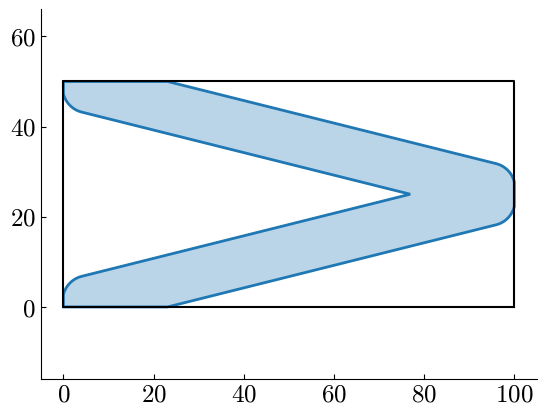

In [5]:
parameterization = Capsules(topology, symmetry_x=False, symmetry_y=True, n_components=1, n_samples=1000, representation=MMCEndpointsConfig, transformer=StraightBeam)

x = np.zeros(parameterization.dimension).reshape(-1, parameterization.dimnesion_per_mmc)
# regular MMC parameters
x[0] = (0, 0, 1, .5, .1)

parameterization.update_topology(topology, x)
topology.plot()

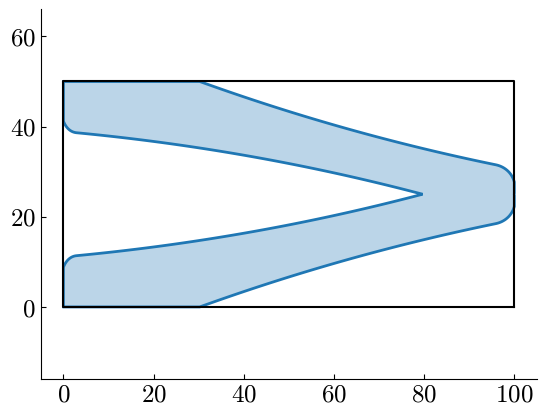

In [6]:
topology = Topology(continuous=True, domain=box(0, 0, 100, 50), density=1.)
parameterization = Capsules(topology, symmetry_x=False, symmetry_y=True, n_components=1, n_samples=1000, representation=MMCEndpointsConfig, transformer=GuoBeam(n_samples=1000))

x = np.zeros(parameterization.dimension).reshape(-1, parameterization.dimnesion_per_mmc)
# regular MMC parameters + transformation parameters
x[0] = (0, 0, 1, .5, .1) + (.2, .1, .5, .5, .5)

parameterization.update_topology(topology, x)
topology.plot()

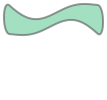

In [7]:
x[0] = (0, 0, 1, 0, .1) + (.3, .3, 1, .75, .5)
# very artistic
parameterization.compute_geometry(x)

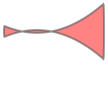

In [8]:
x[0] = (0, 0, 1, 0, .01) + (.5, .1, .5, .5, .5)

parameterization.compute_geometry(x)

The thickness interpolation scheme seems to be a bit flawed for certain combinations of $(r_y,r_1, r_2)$, i.e. if $r_y$ small compared to $r_1$ and $r_2$ often the quadratic interpolation will be negative.

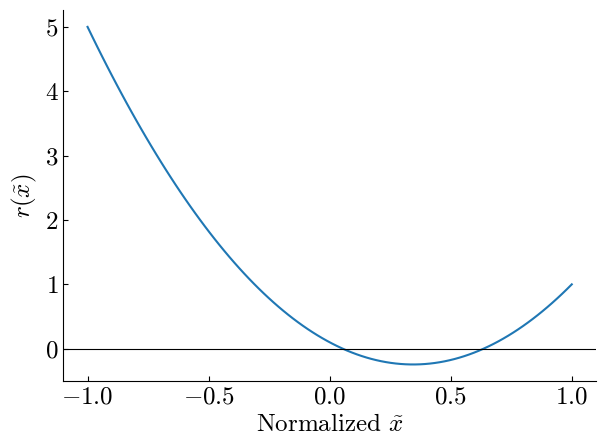

In [9]:
ry = 0.1
r1 = 5
r2 = 1

x_norm = np.linspace(-1, 1, 100)
r_intp = (r1 + r2 - 2*ry) / 2 * (x_norm)**2 + (r2 - r1)/2 * (x_norm) + ry

plt.plot(x_norm, r_intp)
plt.axhline(0, c='k', lw=.8); plt.xlabel(r'Normalized $\tilde{x}$'); plt.ylabel(r'$r(\tilde{x})$'); plt.tight_layout()

In [10]:
class GuoBeam(StraightBeam):
    dimension: int = 5

    def __init__(self, n_samples: int) : self.n_samples = n_samples

    def get_normalization_factors(self, topology: Topology, symmetry_x: bool, symmetry_y: bool) :
        self.rnorm = np.hypot(topology.domain_size_x, topology.domain_size_y)/2
        return np.array([self.rnorm, self.rnorm, self.rnorm/4, self.rnorm/4, 2*np.pi])

    def transform_pre_scale_y(self, geo: Polygon, config: MMCAngularConfig, x_scaled: np.ndarray):
        (r_left, r_right, a, b, phi) = x_scaled.flatten()
        (a, b, phi) = (a-self.rnorm/8, b-self.rnorm/8, phi-np.pi)

        (x, y) = sample_equidistant_pts(np.c_[geo.exterior.xy], self.n_samples).T

        ry = (r_left + r_right - 2*config.ry) / 2 * (x/config.rx)**2 + (r_right - r_left)/2 * (x/config.rx) + config.ry
        f = a*np.sin(b*(x/config.rx + phi))
        y = (f + ry*y)/config.ry
        
        return Polygon(np.c_[x, y]).buffer(1e-2) # easy fix for preventing self-intersecting geometries

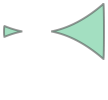

In [11]:
x[0] = (0, 0, 1, 0, .01) + (.5, .1, .5, .5, .5)

parameterization = Capsules(topology, symmetry_x=False, symmetry_y=True, n_components=1, n_samples=1000, representation=MMCEndpointsConfig, transformer=GuoBeam(n_samples=1000))
parameterization.compute_geometry(x)

This will produce this legal geometry now, maybe the disconnected components results in some quirky results idk.

In [12]:
best_configs = []
for i in trange(3):
    with capture_output():
        problem = create_horizontal_cantilever_problem(topology, parameterization)
        run_experiment(problem, budget=500, sigma0=0.25, seed=i+1, name='notebook-intersection-fix')
        best_configs.append((problem.score_best, problem.x_best))

100%|██████████| 3/3 [02:40<00:00, 53.65s/it]


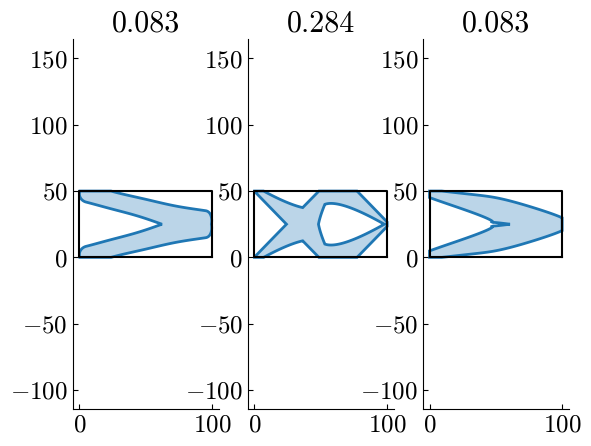

In [13]:
fig, ax = plt.subplots(1, 3)

for j, (score, x) in enumerate(best_configs) :
    parameterization.update_topology(topology, x)
    topology.plot(ax[j]); ax[j].set_title(f'{score:.3f}')

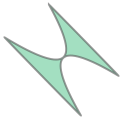

In [14]:
(_, x) = best_configs[1]

parameterization.compute_geometry(x)

It seems to cheat the idea of only using one beam and is going for two parallel beams by using an extreme configuration.

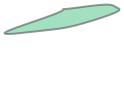

In [15]:
(_, x) = best_configs[2]

parameterization.compute_geometry(x)

In [16]:
class GuoBeamRelativeThickness(StraightBeam):
    dimension: int = 5

    def __init__(self, n_samples: int) : self.n_samples = n_samples

    def get_normalization_factors(self, topology: Topology, symmetry_x: bool, symmetry_y: bool) :
        self.rnorm = np.hypot(topology.domain_size_x, topology.domain_size_y)/2
        # we normalize r1 and r2 as it is -> 0-1 instead of rnorm
        return np.array([1, 1, self.rnorm/4, self.rnorm/4, 2*np.pi])

    def transform_pre_scale_y(self, geo: Polygon, config: MMCAngularConfig, x_scaled: np.ndarray):
        (r_left, r_right, a, b, phi) = x_scaled.flatten()
        (a, b, phi) = (a-self.rnorm/8, b-self.rnorm/8, phi-np.pi)

        # let's linearly map 0-1 to 0.25-4 * config.ry

        r_left = ((4 - 0.25)*r_left + 0.25) * config.ry
        r_right = ((4 - 0.25)*r_right + 0.25) * config.ry

        (x, y) = sample_equidistant_pts(np.c_[geo.exterior.xy], self.n_samples).T

        ry = (r_left + r_right - 2*config.ry) / 2 * (x/config.rx)**2 + (r_right - r_left)/2 * (x/config.rx) + config.ry
        f = a*np.sin(b*(x/config.rx + phi))
        y = (f + ry*y)/config.ry
        
        return Polygon(np.c_[x, y]).buffer(1e-2)

In [17]:
parameterization = Capsules(topology, symmetry_x=False, symmetry_y=True, n_components=1, n_samples=1000, representation=MMCEndpointsConfig, transformer=GuoBeamRelativeThickness(n_samples=1000))
x = np.zeros((parameterization.n_components, parameterization.dimnesion_per_mmc))

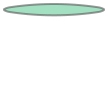

In [18]:
x[0] = (0, 0, 1, 0, .1) + (0, 0, .5, .5, .5)
parameterization.compute_geometry(x)

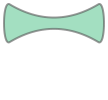

In [19]:
x[0] = (0, 0, 1, 0, .1) + (1, 1, .5, .5, .5)
parameterization.compute_geometry(x)

In [20]:
best_configs = []
for i in trange(3):
    with capture_output():
        problem = create_horizontal_cantilever_problem(topology, parameterization)
        run_experiment(problem, budget=500, sigma0=0.25, seed=i+1, name='relative-radii')
        best_configs.append((problem.score_best, problem.x_best))

100%|██████████| 3/3 [02:48<00:00, 56.01s/it]


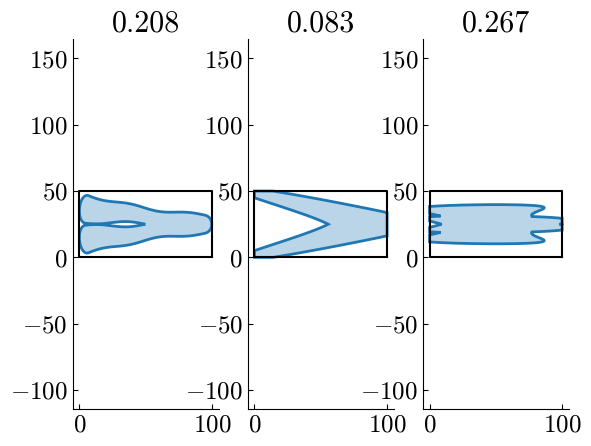

In [21]:
fig, ax = plt.subplots(1, 3)

for j, (score, x) in enumerate(best_configs) :
    parameterization.update_topology(topology, x)
    topology.plot(ax[j]); ax[j].set_title(f'{score:.3f}')

In [22]:
parameterization = Capsules(
    topology, 
    symmetry_x=False, 
    symmetry_y=True, 
    n_components=3, 
    n_samples=1000, 
    representation=MMCEndpointsConfig, 
    transformer=GuoBeam(n_samples=1000)
)

problem = create_horizontal_cantilever_problem(topology, parameterization)
run_experiment(problem, budget=500, sigma0=0.25, seed=i+1, name='notebook-test')

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 30 (seed=3, Tue Apr  8 18:17:06 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 4.859999999999998e+07 1.0e+00 2.34e-01  2e-01  2e-01 0:00.1
    2     28 4.819228142073002e+04 1.1e+00 2.26e-01  2e-01  2e-01 0:00.2
    3     42 4.333015416720629e+04 1.1e+00 2.22e-01  2e-01  2e-01 0:00.3
   34    476 1.262860018761395e+04 1.5e+00 1.80e-01  2e-01  2e-01 0:03.4
   66    924 3.230423400201684e-01 1.7e+00 9.96e-02  9e-02  1e-01 0:07.5
   95   1330 7.544146343288105e-01 1.8e+00 7.16e-02  6e-02  8e-02 0:12.5
  100   1400 6.832477761593108e-01 1.9e+00 7.06e-02  6e-02  8e-02 0:13.8
  117   1638 4.514718058197404e-01 2.0e+00 6.05e-02  5e-02  6e-02 0:21.1
  127   1778 1.884419490069772e-01 2.0e+00 4.23e-02  3e-02  5e-02 0:29.8
  139   1946 1.995478813345946e-01 2.1e+00 3.09e-02  2e-02  3e-02 0:39.3
  153   2142 1.674036903316774e-01 2.1e+00 2.46e-02  2e-02  3e-02 0:49.7
  167   2338 1.355199767272189e-01 2.2

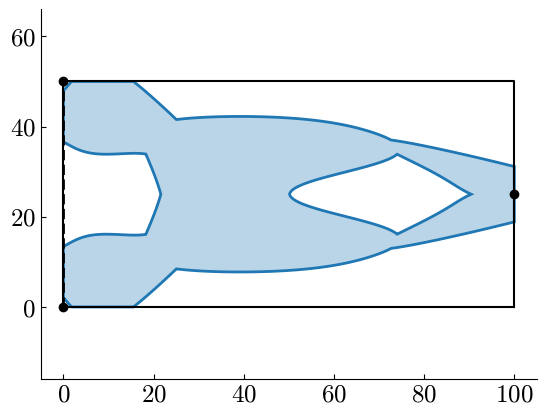

In [24]:
problem.plot_best()